# Tier A: The Statistician

Here, we will use only the mathematical differentiating factors which we say in class 1.

As a reminder of all the mathematical interpretations we made, refer to this table

## Task 1 Summary & Results

| Category | Test | Metric | Class 1 (Human) | Class 2 (AI) | Class 3 (AI-Mimicry) | Hypothesis Confirmed | Key Finding |
|----------|------|--------|-----------------|--------------|----------------------|---------------------|-------------|
| **I. Lexical Richness** | Type-Token Ratio (TTR) | Vocabulary diversity | Lower variance, mid-range | Higher, narrow band (0.6-0.8) | Higher, narrow band | Partially | AI has higher TTR but lower variance; humans show more dynamic range |
| | Hapax Legomena | Words appearing once | Lower | Moderately higher | Moderately higher | Yes | High temperature (1.0) leads to more rare words in AI |
| | Zipf's Law (α exponent) | Power-law distribution | α ≈ 2.7 (steeper) | α ≈ 2.5 (flatter) | α ≈ 2.5 (flatter) | Yes | AI has flatter distribution (heavier tail) due to temperature |
| | Zipf's Law (MAPE) | Fit quality | Higher error | Lower error | Lower error | N/A | AI follows Zipf more consistently |
| **II. Syntactic Complexity** | Dependency Tree Depth | Sentence nesting | Higher avg, wider range | Lower avg (2.56) | Highest avg (over-corrected) | Yes | Humans use more center-embedding; AI prefers right-branching |
| | POS: Adj/Noun Ratio | Descriptive density | Lower | **Higher** | Higher | Yes | AI over-describes compared to humans |
| | POS: Noun/Verb Ratio | Nominalization | Higher (2.32) | Lower (1.72) | Mid-range | Yes | Humans prefer nominalizations; AI prefers direct verbs |
| | POS: Adverb/Verb Ratio | Adverbial modification | Lower | **Higher** | Higher | Yes | AI over-modifies verbs with adverbs |
| **III. Punctuation** | Em-dashes | Stylistic interruption | Lowest | Mid | Highest | Yes | AI mimicry over-uses em-dashes |
| | Semicolons | Complex coordination | **Highest** | Lower | Lower | Yes | Humans use semicolons more for nuanced connections |
| | Colons | Explanatory structure | **Highest** | Lower | Lower | Yes | Humans introduce explanations more formally |
| | Exclamation Points | Emotional expression | **Highest** | Lower | Lower | Yes | Humans express emotion more freely |
| | Double Quotes | Dialogue/citation | **Highest** | Lower | Lower | Yes | Humans use dialogue/quotes more naturally |
| **IV. Readability** | Flesch-Kincaid Grade | Reading difficulty (mean) | 9th grade | 7th grade | 11th grade | Yes | AI writes simpler; mimicry over-corrects to harder |
| | Flesch-Kincaid (variance) | Consistency | **High** (σ ≈ 7) | Very low (σ ≈ 2) | Very low (σ ≈ 2) | Yes | AI maintains constant difficulty; humans modulate |
| **V. Information Theory** | Perplexity (GPT-2) | Predictability | Higher | Lower | Mid | Yes | AI-generated text is more predictable to language models |

We will now use all these findings to train an XGBoost model and a Random Forest Regressor Model.

In task-1, the file [../task-1/math.csv](../task-1/math.csv) file, which stored all the data for each text file which was being analysed.  

Obviously, it will cause significant overfitting if I train it on the full [math.csv](../task-1/math.csv), which has 3922 datapoints. Also, our math.csv contains `author` and `text_file_name`. We'll have to drop these before training to prevent data leakage. 

# XGBoost
## Understanding XGBoost

[XGBoost](https://www.geeksforgeeks.org/machine-learning/xgboost/) (eXtreme Gradient Boosting), is a highly optimized gradient boosting model. It has a few features that help it stand out:

1. It applies both L1 and L2 regularisation. This helps to prevent overfitting.
2. It had built in capabilities to handle missing values, reducing the need for extensive data pre-processing.
3. It has built in cross validation features, and you don't need to use any external Python libraries.
4. It is very good at parallelization, making it very good for large datasets.

It works by (1) starting with a base learner, (2) calculating loss, (3) train the next tree on the basis of the errors of the first tree, (4) repeat.

## Implementation

To create a split, we can use scikitlearns's train-test split python function to split our csv file. We will use XGBoostClassifier's model to train it.

In [14]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import pandas as pd

df = pd.read_csv('../task-1/math.csv')

# First, let's check what columns we have
print("Available columns:", df.columns.tolist())

X = df.drop(columns=['class', 'text_file_name', 'author', 'word_count']) 

class_mapping = {
    'Class 1: Human-written': 0,
    'Class 2: AI-written': 1,
    'Class 3: AI-mimicry': 2
}
y = df['class'].map(class_mapping)

print("BINARY CLASSIFICATION RESULTS")

# Binary Classification 1: Class 1 vs Class 2
mask_12 = (y == 0) | (y == 1)
X_12, y_12 = X[mask_12], y[mask_12]
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(
    X_12, y_12, test_size=0.2, stratify=y_12, random_state=42
)
model_12 = XGBClassifier()
model_12.fit(X_train_12, y_train_12)
accuracy_12 = model_12.score(X_test_12, y_test_12)
print(f"\nClass 1 (Human) vs Class 2 (AI): {accuracy_12:.4f} ({accuracy_12*100:.2f}%)")

# Binary Classification 2: Class 1 vs Class 3
mask_13 = (y == 0) | (y == 2)
X_13, y_13 = X[mask_13], y[mask_13]
# Remap labels: 0 stays 0, 2 becomes 1
y_13_binary = y_13.map({0: 0, 2: 1})
X_train_13, X_test_13, y_train_13, y_test_13 = train_test_split(
    X_13, y_13_binary, test_size=0.2, stratify=y_13_binary, random_state=42
)
model_13 = XGBClassifier()
model_13.fit(X_train_13, y_train_13)
accuracy_13 = model_13.score(X_test_13, y_test_13)
print(f"Class 1 (Human) vs Class 3 (AI-mimicry): {accuracy_13:.4f} ({accuracy_13*100:.2f}%)")

# Binary Classification 3: Class 2 vs Class 3
mask_23 = (y == 1) | (y == 2)
X_23, y_23 = X[mask_23], y[mask_23]
# Remap labels: 1 becomes 0, 2 becomes 1
y_23_binary = y_23.map({1: 0, 2: 1})
X_train_23, X_test_23, y_train_23, y_test_23 = train_test_split(
    X_23, y_23_binary, test_size=0.2, stratify=y_23_binary, random_state=42
)
model_23 = XGBClassifier()
model_23.fit(X_train_23, y_train_23)
accuracy_23 = model_23.score(X_test_23, y_test_23)
print(f"Class 2 (AI) vs Class 3 (AI-mimicry): {accuracy_23:.4f} ({accuracy_23*100:.2f}%)")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
model = XGBClassifier()
model.fit(X_train, y_train)
accuracy = model.score(X_test, y_test)
print(f"\nAll 3 classes: {accuracy:.4f} ({accuracy*100:.2f}%)")

Available columns: ['class', 'text_file_name', 'author', 'word_count', 'ttr', 'hapax_ratio', 'zipf_alpha', 'zipf_mape', 'avg_parse_depth', 'adj_noun_ratio', 'noun_verb_ratio', 'adverb_verb_ratio', 'em_dash_freq', 'semicolon_freq', 'colon_freq', 'exclamation_freq', 'double_quote_freq', 'flesch_kincaid_grade']
BINARY CLASSIFICATION RESULTS

Class 1 (Human) vs Class 2 (AI): 0.8898 (88.98%)
Class 1 (Human) vs Class 3 (AI-mimicry): 0.9319 (93.19%)
Class 2 (AI) vs Class 3 (AI-mimicry): 0.8372 (83.72%)

All 3 classes: 0.8229 (82.29%)


## Misclassified Texts
Nice, it's running with 88.98% accuracy for class 1 vs 2 and 93% for class 1 vs class 3. Let me see where it's going right, where it's going wrong, and then I'll try to analyse that.

In [17]:
import numpy as np
import os

y_pred = model.predict(X_test)

results_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred,
    'text_file': df.loc[y_test.index, 'text_file_name'].values
})

reverse_mapping = {0: 'Class 1: Human-written', 1: 'Class 2: AI-written', 2: 'Class 3: AI-mimicry'}

# Create output directory
output_dir = 'xgboost_misclassified'
os.makedirs(output_dir, exist_ok=True)

# Define misclassification categories
categories = [
    (0, 1, 'class1_as_class2.txt', 'Class 1 (Human) misclassified as Class 2 (AI)'),
    (0, 2, 'class1_as_class3.txt', 'Class 1 (Human) misclassified as Class 3 (AI-mimicry)'),
    (1, 0, 'class2_as_class1.txt', 'Class 2 (AI) misclassified as Class 1 (Human)'),
    (1, 2, 'class2_as_class3.txt', 'Class 2 (AI) misclassified as Class 3 (AI-mimicry)'),
    (2, 0, 'class3_as_class1.txt', 'Class 3 (AI-mimicry) misclassified as Class 1 (Human)'),
    (2, 1, 'class3_as_class2.txt', 'Class 3 (AI-mimicry) misclassified as Class 2 (AI)')
]

total_saved = 0

for actual_class, predicted_class, filename, description in categories:
    # Filter misclassified examples for this category
    category_misclassified = results_df[(results_df['actual'] == actual_class) & 
                                        (results_df['predicted'] == predicted_class)]
    
    if len(category_misclassified) == 0:
        continue
    
    filepath = os.path.join(output_dir, filename)
    
    with open(filepath, 'w', encoding='utf-8') as outfile:
        outfile.write("=" * 80 + "\n")
        outfile.write(f"{description}\n")
        outfile.write(f"Total: {len(category_misclassified)} files\n")
        outfile.write("=" * 80 + "\n\n")
        
        for idx, row in category_misclassified.iterrows():
            text_file = row['text_file']
            actual = row['actual']
            predicted = row['predicted']
            
            # Construct the full path to the text file
            actual_class_folder = f"class{actual+1}-{'human-written' if actual == 0 else 'ai-written' if actual == 1 else 'ai-mimicry'}"
            
            # Find the file in the dataset
            base_path = '../dataset'
            file_path = None
            
            # Search for the file
            for root, dirs, files in os.walk(os.path.join(base_path, actual_class_folder)):
                if text_file in files:
                    file_path = os.path.join(root, text_file)
                    break
            
            if file_path and os.path.exists(file_path):
                outfile.write("-" * 80 + "\n")
                outfile.write(f"File: {text_file}\n")
                outfile.write(f"Actual: {reverse_mapping[actual]}\n")
                outfile.write(f"Predicted: {reverse_mapping[predicted]}\n")
                outfile.write("-" * 80 + "\n")
                
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        outfile.write(content)
                except Exception as e:
                    outfile.write(f"Error reading file: {e}\n")
                
                outfile.write("\n\n")
            else:
                outfile.write(f"Could not find file: {text_file}\n\n")
    
    total_saved += len(category_misclassified)
    print(f"Saved {len(category_misclassified)} files to {filename}")

print(f"\nTotal: {total_saved} misclassified text files saved to {output_dir}/")

Saved 30 files to class1_as_class2.txt
Saved 13 files to class1_as_class3.txt
Saved 31 files to class2_as_class1.txt
Saved 25 files to class2_as_class3.txt
Saved 19 files to class3_as_class1.txt
Saved 21 files to class3_as_class2.txt

Total: 139 misclassified text files saved to xgboost_misclassified/


The files have been saved to [xgboost_misclassified/](xgboost_misclassified/), you can see the misclassified files. 

I want to see how prominent each specific statistical test is towards the final output.

## Prominence of each statistical test towards the final output

FEATURE IMPORTANCE ANALYSIS

All Statistical Tests Ranked by Importance:
    Statistical_Test  Importance_Score
        em_dash_freq          0.289679
         hapax_ratio          0.111986
    exclamation_freq          0.111343
      semicolon_freq          0.091894
flesch_kincaid_grade          0.067786
          colon_freq          0.062475
     avg_parse_depth          0.060763
   double_quote_freq          0.055033
          zipf_alpha          0.034469
     noun_verb_ratio          0.033843
      adj_noun_ratio          0.028138
   adverb_verb_ratio          0.027305
           zipf_mape          0.025286
                 ttr          0.000000


Most Prominent Test: em_dash_freq
Importance Score: 0.2897


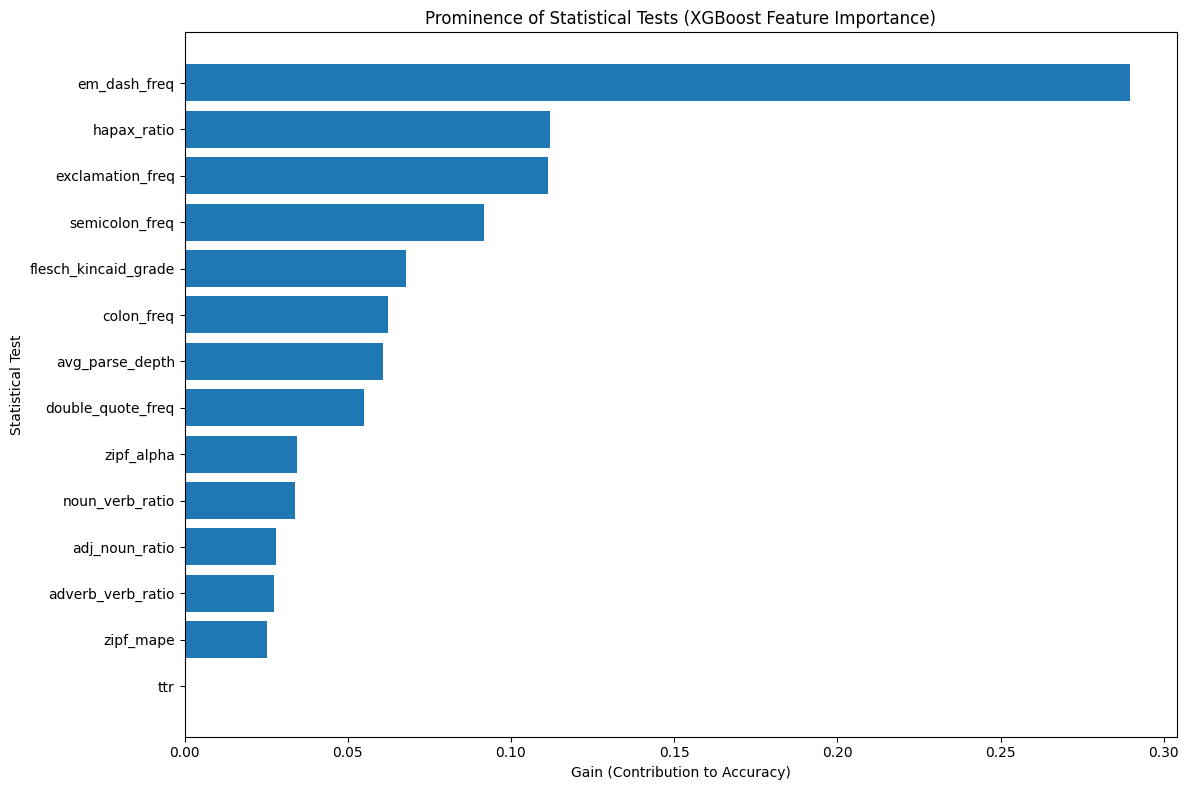

In [22]:
import matplotlib.pyplot as plt

# Feature importance is already calculated from the model above
# Let's create a more detailed analysis

print("FEATURE IMPORTANCE ANALYSIS")

# Create importance dataframe
importance_df = pd.DataFrame({
    'Statistical_Test': X.columns,
    'Importance_Score': model.feature_importances_
}).sort_values(by='Importance_Score', ascending=False)

print("\nAll Statistical Tests Ranked by Importance:")
print(importance_df.to_string(index=False))

print("\n")
print(f"Most Prominent Test: {importance_df.iloc[0]['Statistical_Test']}")
print(f"Importance Score: {importance_df.iloc[0]['Importance_Score']:.4f}")

# Visualize Feature Importance
plt.figure(figsize=(12, 8))
importance_df_plot = importance_df.sort_values(by='Importance_Score', ascending=True)
plt.barh(importance_df_plot['Statistical_Test'], importance_df_plot['Importance_Score'])
plt.title("Prominence of Statistical Tests (XGBoost Feature Importance)")
plt.xlabel("Gain (Contribution to Accuracy)")
plt.ylabel("Statistical Test")
plt.tight_layout()
plt.show()

## Results

Very, very interesting, but not too surprising.
**By far**, the em-dash is the leading indicator of AI in the scripts, with in importance score of >0.28. Meanwhile, TTR played no significance at all, with an importance score of 0.000000  

This makes sense, since if we look at the results for TTR, it's variance for was low, and centred with only a slightly higher average than that of humans. 

# Random Forest
## Understanding Random Forest

[Random Forest](https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/) is an ensemble learning method that operates by constructing multiple decision trees during training and outputting the class that is the mode of the classes from individual trees.

Key features:

1. It reduces overfitting by averaging multiple decision trees trained on different parts of the same dataset.
2. It handles missing values well and maintains accuracy even when a large proportion of data is missing.
3. It provides estimates of feature importance, showing which variables are most important for classification.
4. It's robust to outliers and non-linear data.

It works by (1) creating multiple decision trees from random subsets of the data, (2) each tree votes for a class, (3) the final prediction is the majority vote.

## Implementation

We'll use the same train-test split approach, but this time with scikit-learn's RandomForestClassifier.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

df = pd.read_csv('../task-1/math.csv')

# First, let's check what columns we have
print("Available columns:", df.columns.tolist())

X = df.drop(columns=['class', 'text_file_name', 'author', 'word_count']) 

class_mapping = {
    'Class 1: Human-written': 0,
    'Class 2: AI-written': 1,
    'Class 3: AI-mimicry': 2
}
y = df['class'].map(class_mapping)

print("BINARY CLASSIFICATION RESULTS - RANDOM FOREST")

# Binary Classification 1: Class 1 vs Class 2
mask_12 = (y == 0) | (y == 1)
X_12, y_12 = X[mask_12], y[mask_12]
X_train_12, X_test_12, y_train_12, y_test_12 = train_test_split(
    X_12, y_12, test_size=0.2, stratify=y_12, random_state=42
)
model_rf_12 = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_12.fit(X_train_12, y_train_12)
accuracy_rf_12 = model_rf_12.score(X_test_12, y_test_12)
print(f"\nClass 1 (Human) vs Class 2 (AI): {accuracy_rf_12:.4f} ({accuracy_rf_12*100:.2f}%)")

# Binary Classification 2: Class 1 vs Class 3
mask_13 = (y == 0) | (y == 2)
X_13, y_13 = X[mask_13], y[mask_13]
# Remap labels: 0 stays 0, 2 becomes 1
y_13_binary = y_13.map({0: 0, 2: 1})
X_train_13, X_test_13, y_train_13, y_test_13 = train_test_split(
    X_13, y_13_binary, test_size=0.2, stratify=y_13_binary, random_state=42
)
model_rf_13 = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_13.fit(X_train_13, y_train_13)
accuracy_rf_13 = model_rf_13.score(X_test_13, y_test_13)
print(f"Class 1 (Human) vs Class 3 (AI-mimicry): {accuracy_rf_13:.4f} ({accuracy_rf_13*100:.2f}%)")

# Binary Classification 3: Class 2 vs Class 3
mask_23 = (y == 1) | (y == 2)
X_23, y_23 = X[mask_23], y[mask_23]
# Remap labels: 1 becomes 0, 2 becomes 1
y_23_binary = y_23.map({1: 0, 2: 1})
X_train_23, X_test_23, y_train_23, y_test_23 = train_test_split(
    X_23, y_23_binary, test_size=0.2, stratify=y_23_binary, random_state=42
)
model_rf_23 = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf_23.fit(X_train_23, y_train_23)
accuracy_rf_23 = model_rf_23.score(X_test_23, y_test_23)
print(f"Class 2 (AI) vs Class 3 (AI-mimicry): {accuracy_rf_23:.4f} ({accuracy_rf_23*100:.2f}%)")

# Keep the multi-class model for the next cell
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
accuracy_rf = model_rf.score(X_test, y_test)
print(f"\nMulti-class (All 3 classes): {accuracy_rf:.4f} ({accuracy_rf*100:.2f}%)")

Available columns: ['class', 'text_file_name', 'author', 'word_count', 'ttr', 'hapax_ratio', 'zipf_alpha', 'zipf_mape', 'avg_parse_depth', 'adj_noun_ratio', 'noun_verb_ratio', 'adverb_verb_ratio', 'em_dash_freq', 'semicolon_freq', 'colon_freq', 'exclamation_freq', 'double_quote_freq', 'flesch_kincaid_grade']
BINARY CLASSIFICATION RESULTS - RANDOM FOREST

Class 1 (Human) vs Class 2 (AI): 0.8780 (87.80%)
Class 1 (Human) vs Class 3 (AI-mimicry): 0.9302 (93.02%)
Class 2 (AI) vs Class 3 (AI-mimicry): 0.8346 (83.46%)

Multi-class (All 3 classes): 0.8331 (83.31%)


Nice again! 87% accuracy for class-1 vs class-2, and 93% for class-1 vs class-3

## Misclassified Texts
Here we analyze where the Random Forest model makes mistakes and save those examples.

In [20]:
import numpy as np
import os

y_pred_rf = model_rf.predict(X_test)

results_df_rf = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_pred_rf,
    'text_file': df.loc[y_test.index, 'text_file_name'].values
})

reverse_mapping = {0: 'Class 1: Human-written', 1: 'Class 2: AI-written', 2: 'Class 3: AI-mimicry'}

# Create output directory
output_dir_rf = 'randomforest_misclassified'
os.makedirs(output_dir_rf, exist_ok=True)

# Define misclassification categories
categories = [
    (0, 1, 'class1_as_class2.txt', 'Class 1 (Human) misclassified as Class 2 (AI)'),
    (0, 2, 'class1_as_class3.txt', 'Class 1 (Human) misclassified as Class 3 (AI-mimicry)'),
    (1, 0, 'class2_as_class1.txt', 'Class 2 (AI) misclassified as Class 1 (Human)'),
    (1, 2, 'class2_as_class3.txt', 'Class 2 (AI) misclassified as Class 3 (AI-mimicry)'),
    (2, 0, 'class3_as_class1.txt', 'Class 3 (AI-mimicry) misclassified as Class 1 (Human)'),
    (2, 1, 'class3_as_class2.txt', 'Class 3 (AI-mimicry) misclassified as Class 2 (AI)')
]

total_saved_rf = 0

for actual_class, predicted_class, filename, description in categories:
    # Filter misclassified examples for this category
    category_misclassified_rf = results_df_rf[(results_df_rf['actual'] == actual_class) & 
                                        (results_df_rf['predicted'] == predicted_class)]
    
    if len(category_misclassified_rf) == 0:
        continue
    
    filepath = os.path.join(output_dir_rf, filename)
    
    with open(filepath, 'w', encoding='utf-8') as outfile:
        outfile.write("=" * 80 + "\n")
        outfile.write(f"{description}\n")
        outfile.write(f"Total: {len(category_misclassified_rf)} files\n")
        outfile.write("=" * 80 + "\n\n")
        
        for idx, row in category_misclassified_rf.iterrows():
            text_file = row['text_file']
            actual = row['actual']
            predicted = row['predicted']
            
            # Construct the full path to the text file
            actual_class_folder = f"class{actual+1}-{'human-written' if actual == 0 else 'ai-written' if actual == 1 else 'ai-mimicry'}"
            
            # Find the file in the dataset
            base_path = '../dataset'
            file_path = None
            
            # Search for the file
            for root, dirs, files in os.walk(os.path.join(base_path, actual_class_folder)):
                if text_file in files:
                    file_path = os.path.join(root, text_file)
                    break
            
            if file_path and os.path.exists(file_path):
                outfile.write("-" * 80 + "\n")
                outfile.write(f"File: {text_file}\n")
                outfile.write(f"Actual: {reverse_mapping[actual]}\n")
                outfile.write(f"Predicted: {reverse_mapping[predicted]}\n")
                outfile.write("-" * 80 + "\n")
                
                try:
                    with open(file_path, 'r', encoding='utf-8') as f:
                        content = f.read()
                        outfile.write(content)
                except Exception as e:
                    outfile.write(f"Error reading file: {e}\n")
                
                outfile.write("\n\n")
            else:
                outfile.write(f"Could not find file: {text_file}\n\n")
    
    total_saved_rf += len(category_misclassified_rf)
    print(f"Saved {len(category_misclassified_rf)} files to {filename}")

print(f"\nTotal: {total_saved_rf} misclassified text files saved to {output_dir_rf}/")

Saved 31 files to class1_as_class2.txt
Saved 9 files to class1_as_class3.txt
Saved 35 files to class2_as_class1.txt
Saved 20 files to class2_as_class3.txt
Saved 19 files to class3_as_class1.txt
Saved 17 files to class3_as_class2.txt

Total: 131 misclassified text files saved to randomforest_misclassified/


The files have been saved to [randomforest_misclassified/](randomforest_misclassified/), you can see the misclassified files. 

I want to see how prominent each specific statistical test is towards the final output.

## Prominence of each statistical test towards the final output

FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST

All Statistical Tests Ranked by Importance:
    Statistical_Test  Importance_Score
         hapax_ratio          0.178240
        em_dash_freq          0.114260
flesch_kincaid_grade          0.109520
     avg_parse_depth          0.101444
      semicolon_freq          0.094047
          zipf_alpha          0.092609
     noun_verb_ratio          0.067806
      adj_noun_ratio          0.058275
           zipf_mape          0.057459
   adverb_verb_ratio          0.051683
   double_quote_freq          0.028160
    exclamation_freq          0.024036
          colon_freq          0.022462
                 ttr          0.000000
Most Prominent Test: hapax_ratio
Importance Score: 0.1782


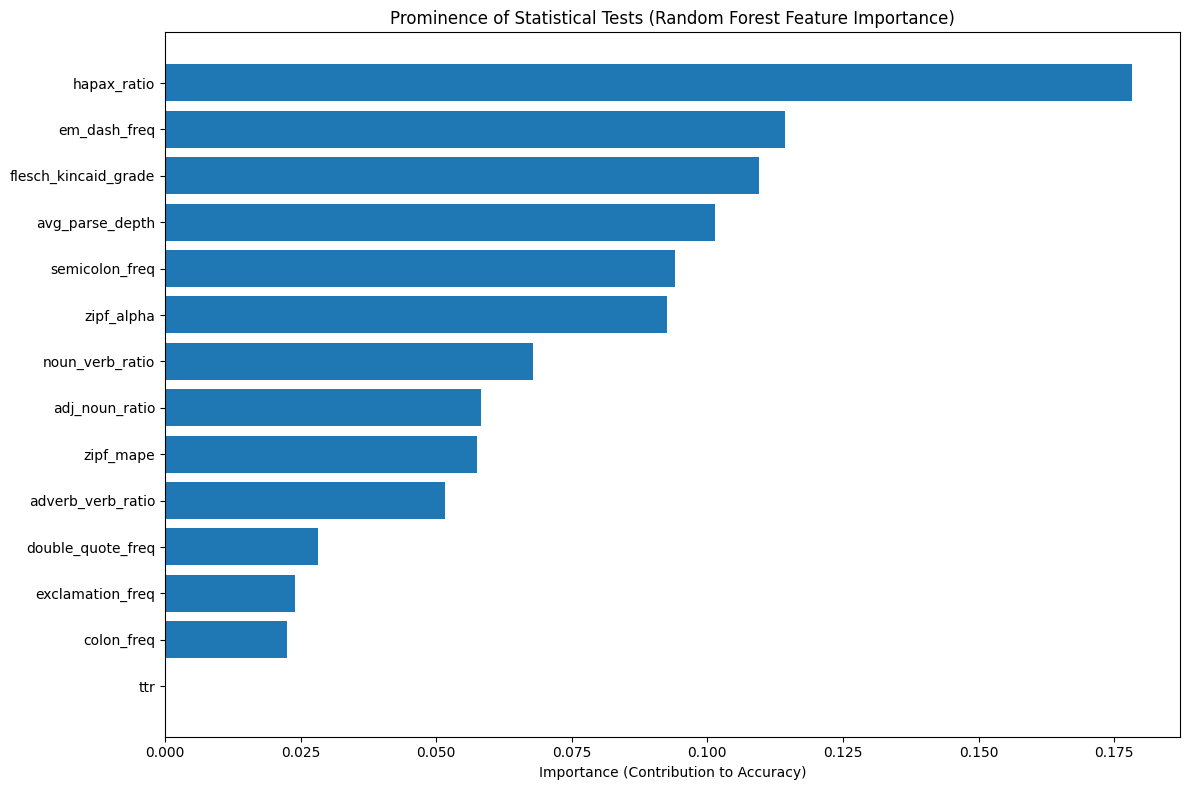

In [21]:
import matplotlib.pyplot as plt

# Feature importance for Random Forest
print("FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST")

# Create importance dataframe
importance_df_rf = pd.DataFrame({
    'Statistical_Test': X.columns,
    'Importance_Score': model_rf.feature_importances_
}).sort_values(by='Importance_Score', ascending=False)

print("\nAll Statistical Tests Ranked by Importance:")
print(importance_df_rf.to_string(index=False))

print(f"Most Prominent Test: {importance_df_rf.iloc[0]['Statistical_Test']}")
print(f"Importance Score: {importance_df_rf.iloc[0]['Importance_Score']:.4f}")

# Visualize Feature Importance
plt.figure(figsize=(12, 8))
importance_df_rf_plot = importance_df_rf.sort_values(by='Importance_Score', ascending=True)
plt.barh(importance_df_rf_plot['Statistical_Test'], importance_df_rf_plot['Importance_Score'])
plt.title("Prominence of Statistical Tests (Random Forest Feature Importance)")
plt.xlabel("Importance (Contribution to Accuracy)")
plt.tight_layout()
plt.show()

## Results

I found this to be very interesting. The XGBoost and Random Forest models have varied orderings and importance scores. em-dash frequency was XGBoost's favourite, but only has an importance score of 0.11 in Random Forest.

This resulted in me going down a rabbit hole as to why this happens...

# Why XGBoost and Random Forest have varied importance orderings

- XGBoost uses gradient boosting, which is an inherently greedy framework. Once it realised that em-dashes were a `high signal` feature, it just decided to exploit that finding, and move on from there.
- Random Forest builds trees in parallel using random subsets of features. In many of its trees, em_dash_freq might not have even been available to select. Consequently, the model was forced to find other reliable predictors, such as hapax_ratio